In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from scipy import stats
from IPython.display import display, HTML
# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style("darkgrid")

##  Bootstrap for Estimating Standard Errors of Logistic Regression Coefficients
### exercise 6 from Chapter 5 of ISLR

### (a)

In [3]:
default_df = pd.read_csv('D:\Columbia\课程\第一学期\machine learning\hw\data_export\Default.csv', index_col=0)
default_df = default_df.reset_index().drop('index', axis=1)


In [4]:
response   = 'default'
predictors = ['income', 'balance']

X_all = sm.add_constant(np.array(default_df[predictors]))
y_all = np.where(default_df['default']=='No', 0, 1) #np.array(default_df[response])

## Logistic regression
m = sm.Logit(y_all, X_all).fit(disp=False);    

# Summary
print(m.summary())

statsmodels_est = pd.DataFrame({'coef_sm': m.params, 'SE_sm': m.bse})
display(statsmodels_est)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Nov 2021   Pseudo R-squ.:                  0.4594
Time:                        13:50:40   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
x1          2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
x2             0.0056      0.000     24.835      0.0

,coef_sm,SE_sm
0,-11.540468,0.434772
1,0.000021,0.000005
2,0.005647,0.000227


### (b)

In [5]:
def boot_fn(df, idx):
    #response   = 'default_Yes'
    predictors = ['income', 'balance']
    
    X = sm.add_constant(np.array(df[predictors].loc[idx]));
    y = np.where(default_df.loc[idx]['default']=='No', 0, 1)
       
    # Logistic regression
    m = sm.Logit(y, X).fit(disp=False);  
    return m.params;

### (c)

In [7]:
def boot_idx(n):
    """Return index for bootstrap sample of size n
    e.g. generate array in range 0 to n, with replacement"""
    return np.random.randint(low=0, high=n, size=n)

def boot(fn, data, R):
    """Perform bootstrap for B number of samples"""
    results = []
    for s in range(R):
        Z = fn(data, boot_idx(data.shape[0]))
        results += [Z]
    return np.array(results)

def standard_deviation(X):
    """Compute deviation error for jth element in matrix X
    equivalent to np.std(X, axis=0)"""
    X_bar = np.mean(X, axis=0)
    SE = np.sqrt((np.sum(np.square(X - X_bar), axis=0)) / (len(X)))
    return SE

B = 10000
coef_preds    = boot(boot_fn, default_df, R=B)
coef_pred     = np.mean(coef_preds, axis=0)
standard_errs = standard_deviation(coef_preds)

bootstrap_est = pd.DataFrame({'coef_boot': coef_pred, 'SE_boot': standard_errs})
display(bootstrap_est)

,coef_boot,SE_boot
0,-11.590256,0.425775
1,0.000021,0.000005
2,0.005660,0.000229


### (d)

In [ ]:
pd.concat([statsmodels_est, bootstrap_est], axis=1)

Let's compare the standard errors estimated by the statsmodels (_sm) summary() function with estimates obtained by bootstrap (_boot) in the table above. The standard errors for x1 and x2 (rows 1 and 2) are indistinguishable to 6 decimal places. The coefficient for x2 and the statistics for the intercept x0 vary slightly.

##  Comparing Lasso, Ridge, and Least Squares
### exercise 9 from Chapter 6 of ISLR

In [9]:

import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets

# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy import stats

### (a)

In [10]:
college_df = pd.read_csv('D:\Columbia\课程\第一学期\machine learning\hw\data_export\College.csv')
# 8(b) label rows by college
college_df = college_df.set_index(['Unnamed: 0'], append=True, verify_integrity=True)
college_df.rename_axis([None, 'College'], inplace=True)

# Get dummimies
college_df = pd.get_dummies(college_df).drop('Private_No', axis=1)

# Convert to floats
college_df = college_df.astype(np.float64)

# Remove fullstops from col names
college_df = college_df.rename(index=str, columns={"F.Undergrad": "F_Undergrad", 
                                                   "P.Undergrad": "P_Undergrad",
                                                   "S.F.Ratio": "S_F_Ratio",
                                                   "perc.alumni": "perc_alumni",
                                                   "Grad.Rate": "Grad_Rate",
                                                   "Room.Board": "Room_Board"})

# Assign train and test sets
np.random.seed(1)
train = np.random.rand(len(college_df)) < 0.5
response   = 'Apps'
X_train = college_df[train].drop(response, axis=1)
X_test  = college_df[~train].drop(response, axis=1)
y_train = college_df[train][response]
y_test  = college_df[~train][response]


display(X_train.head())

,,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
,College,,,,,,,,,,,,,,,,,
0,Abilene Christian University,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0,1.0
2,Adrian College,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0,1.0
3,Agnes Scott College,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0,1.0
4,Alaska Pacific University,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0,1.0
5,Albertson College,479.0,158.0,38.0,62.0,678.0,41.0,13500.0,3335.0,500.0,675.0,67.0,73.0,9.4,11.0,9727.0,55.0,1.0


### (b)

In [12]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size
# OLS
# Use all available features
f = '{} ~ {}'.format(response, '+'.join(X_train.columns))

# Fit model
model = smf.ols(formula=f, data=pd.concat([X_train, y_train], axis=1)).fit()
y_hat = model.predict(X_test)
print('RMSE: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE: 1229.1326212399854


### (c)

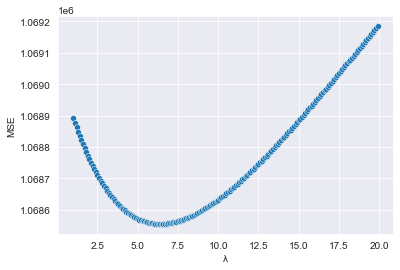

RMSE CV: 1033.7092919308889
@Lambda: 6.400000000000005


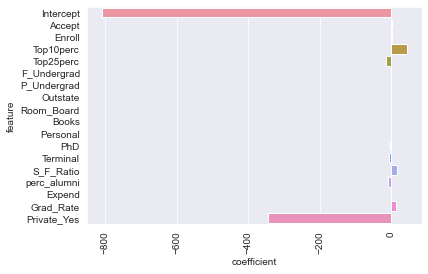

,feature,coefficient
0,Intercept,-808.261769
1,Accept,1.240118
2,Enroll,0.293775
3,Top10perc,42.238162
4,Top25perc,-14.374250
5,F_Undergrad,-0.012896
6,P_Undergrad,0.057522
7,Outstate,-0.055904
8,Room_Board,0.135773
9,Books,-0.191998


In [17]:
# Perform 10 fold cross validation to find optimal λ

def ridge_cv(X, y, λ, k):
    """Perform ridge regresion with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Ridge(alpha=λ, fit_intercept=True, normalize=False, solver='cholesky')
        m = model.fit(X_train, y_train)
        
        # Measure MSE
        y_hat = m.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

def optimise(X, y, cv, lambdas):
    MSEs = [] 
    for l in lambdas:
        MSEs += [np.mean(cv(X, y, λ=l, k=10))]
    
    sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
    plt.show();
    
    lamb = min(zip(MSEs, lambdas))
    print('RMSE CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))
    λ = min(zip(MSEs, lambdas))[1]
    # What coefficients does ridge regression choose for the optimal lambda value?
    model = linear_model.Ridge(alpha=λ, fit_intercept=True, normalize=False, solver='cholesky')
    m = model.fit(X, y)
    
    intercept = pd.DataFrame({'feature': 'Intercept', 'coefficient': [m.intercept_]})
    ridge_df  = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': m.coef_}), ignore_index=True)
    
    ax = sns.barplot(x='coefficient', y='feature', data=ridge_df)
    plt.xticks(rotation=90)
    plt.show();
    
    display(ridge_df)
    return lamb[1]

     
opt_lamb = optimise(X_train, y_train, ridge_cv, np.arange(1, 20, .1))

In [18]:
# Use optimal lambda value optained in previous step, then test model on test set.
model = model = linear_model.Ridge(alpha=opt_lamb, fit_intercept=True, normalize=False, solver='cholesky')
# Fit on full training setl
model.fit(X_train, y_train)
# Get test rmse
y_hat = model.predict(X_test)
print('RMSE Test: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE Test: 1230.2863913806934


With an RSME on the test set of 1230.29, ridge regression performs marginally worse than a naive linear regression with all feature

### (d)

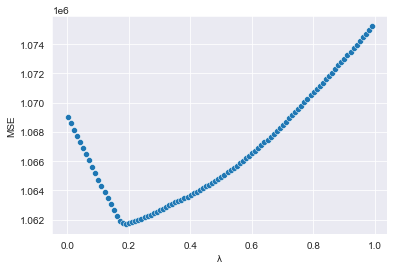

RMSE CV: 1030.3953270677766
@Lambda: 0.19099999999999998


In [19]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                                   normalize=True, positive=False, precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

lambdas = np.arange(.001, 1, .01)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X_train, y_train, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

lamb = min(zip(MSEs, lambdas))
print('RMSE CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))

In [20]:
def lasso_test(λ):
    # Fit model on full training set with optimal lambda
    model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                               normalize=True, positive=False, precompute=False, random_state=None,
                               selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
    
    # Get test rmse
    y_hat = model.predict(X_test)
    print('RMSE Test: {}'.format(np.sqrt(mse(y_hat, y_test))))
    
    # # What coefficients does the lasso choose for the optimal lambda value?
    intercept = pd.DataFrame({'feature': 'Intercept', 'coefficient': [model.intercept_]})
    lasso_df  = intercept.append(pd.DataFrame({'feature': X_train.columns, 'coefficient': model.coef_}), ignore_index=True)
    
    ax = sns.barplot(x='coefficient', y='feature', data=lasso_df);
    plt.xticks(rotation=90)
    plt.show();
    
    display(lasso_df)

interact(lasso_test, λ=widgets.FloatSlider(min=lamb[1]/100, max=lamb[1]*10, step=0.01, value=lamb[1]));

interactive(children=(FloatSlider(value=0.19099999999999998, description='λ', max=1.9099999999999997, min=0.00…

### (g)

In [21]:
# Functions to emulate R's lm().plot() functionality
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions


def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

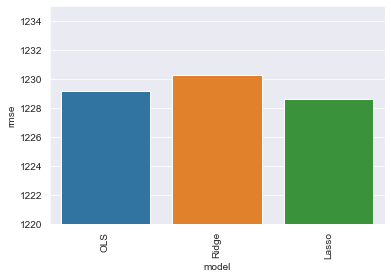

,model,rmse
0,OLS,1229.13
1,Ridge,1230.29
2,Lasso,1228.58


In [22]:
models = ['OLS', 'Ridge', 'Lasso']
rmses  = [1229.13, 1230.29,  1228.58]
results = pd.DataFrame({'model': models, 'rmse': rmses})

ax = sns.barplot(x='model', y='rmse', data=results)
ax.set_ylim([1220,1235])
plt.xticks(rotation=90)
plt.show();

display(results)